# Model Research

In [15]:
import os.path

import torch

# Encoding
def encode(list_of_strings, device, pad_token_id=0):
    max_length = max([len(string) for string in list_of_strings])

    # create emtpy tensors
    attention_masks = torch.zeros((len(list_of_strings), max_length), dtype=torch.long)
    input_ids = torch.full((len(list_of_strings), max_length), pad_token_id, dtype=torch.long)

    for idx, string in enumerate(list_of_strings):
        # make sure string is in byte format
        if not isinstance(string, bytes):
            string = str.encode(string)

        input_ids[idx, :len(string)] = torch.tensor([x + 2 for x in string])
        attention_masks[idx, :len(string)] = 1

    return input_ids.to(device), attention_masks.to(device)

# Decoding
def decode(outputs_ids):
    decoded_outputs = []
    for output_ids in outputs_ids.tolist():
        # transform id back to char IDs < 2 are simply transformed to ""
        decoded_outputs.append("".join([chr(x - 2) if x > 1 else "" for x in output_ids]))
    return decoded_outputs

In [16]:
from transformers import ReformerModelWithLMHead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ReformerModelWithLMHead.from_pretrained("google/reformer-enwik8")
model = model.to(device)

/home/yoavjavits/miniconda3/envs/HSC/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
encoded, attention_masks = encode(["In 1965, Brooks left IBM to found the Department of"], device)
decode(model.generate(encoded, do_sample=True, max_length=150))

# gives:
# In 1965, Brooks left IBM to found the Department of Journalism in 1968. IBM had jurisdiction himself in 1980, while Brooks resolved, nevertheless thro

['In 1965, Brooks left IBM to found the Department of Housing and Access Research, and IBM returned to IBM. Per June 1965, experimenting with transfer o']

In [99]:
print(encoded.shape)
print(attention_masks.shape)

torch.Size([1, 44])
torch.Size([1, 51])


In [56]:
print(model)

ReformerModelWithLMHead(
  (reformer): ReformerModel(
    (embeddings): ReformerEmbeddings(
      (word_embeddings): Embedding(258, 1024)
      (position_embeddings): AxialPositionEmbeddings(
        (weights): ParameterList(
            (0): Parameter containing: [torch.float32 of size 128x1x256 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 1x512x768 (cuda:0)]
        )
      )
    )
    (encoder): ReformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x ReformerLayer(
          (attention): ReformerAttention(
            (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (self_attention): LocalSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): ReformerSelfOutput(
              (dense): Linea

In [57]:
print(model.config)

ReformerConfig {
  "_name_or_path": "google/reformer-enwik8",
  "architectures": [
    "ReformerModelWithLMHead"
  ],
  "attention_head_size": 128,
  "attn_layers": [
    "local",
    "local",
    "lsh",
    "local",
    "local",
    "local",
    "lsh",
    "local",
    "local",
    "local",
    "lsh",
    "local"
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": true,
  "axial_pos_embds_dim": [
    256,
    768
  ],
  "axial_pos_shape": [
    128,
    512
  ],
  "chunk_size_lm_head": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "feed_forward_size": 4096,
  "hash_seed": null,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.2,
  "local_attn_chunk_length": 128,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 1,
  "lsh_attention_probs_dropout_prob": 0.1,
  "lsh_attn_chunk_length": 256,
  "lsh_num_chunks_after": 0,
  "l

# Evaluate the model

In [17]:
from data_scripts.data_reformer import Corpus

In [18]:
corpus: Corpus = Corpus("./data/sentences")

In [19]:
def extract_sentences(corpus_):
    eos_id = corpus_.dictionary.char2idx['eos']

    sentences_ = []

    curr_index = 0
    while curr_index < len(corpus_.test):
        sentence = []
        while curr_index < len(corpus_.test) and corpus_.test[curr_index] != eos_id:
            sentence.append(corpus_.test[curr_index])
            curr_index += 1

        sentences_.append(sentence)
        curr_index += 1

    return sentences_

In [20]:
sentences = extract_sentences(corpus)

In [52]:
def create_letters_count(sentence_, corpus_):
    dict_letter = {}
    for char_idx in sentence_:
        char = corpus_.dictionary.idx2char[char_idx]
        
        if char not in dict_letter:
            dict_letter[char] = {'count': 1, 'correct': 0}
            
        else:
            dict_letter[char]['count'] += 1
    
    for char in range(ord('a'), ord('z') + 1):
        char = chr(char)
        if char not in dict_letter:
            dict_letter[char] = {'count': 0, 'correct': 0}
            
    if ' ' not in dict_letter:
        dict_letter[' '] = {'count': 0, 'correct': 0}
    
    return dict_letter

def get_word_lengths(sentence_, backspace_id):
    word_lengths = []

    curr_index = 0
    while curr_index < len(sentence_):
        word = []
        while curr_index < len(sentence_) and sentence_[curr_index] != backspace_id:
            word.append(sentence_[curr_index])
            curr_index += 1

        word_lengths.append(len(word))
        curr_index += 1

    return word_lengths

In [55]:
def calculate_statistics(sentence_, restored_sentence, corpus_):
    backspace_id = corpus_.dictionary.char2idx[' ']

    num_correct = 0
    num_all = len(sentence_)

    num_letters_correct = 0
    num_letters_all = len([c for c in sentence_ if c != backspace_id])

    num_backspace_correct = 0
    num_backspace_all = num_all - num_letters_all

    word_lengths = get_word_lengths(sentence_, backspace_id)
    
    num_first_half_word_correct = 0
    num_first_half_word_all = sum([(c / 2) for c in word_lengths])

    num_second_half_word_correct = 0
    num_second_half_word_all = sum(word_lengths) - num_first_half_word_all
    
    letters_count = create_letters_count(sentence_, corpus_)

    curr_word_index = 0
    curr_word_letter_pos = 0
    for i in range(len(sentence_)):
        if sentence_[i] == restored_sentence[i]:
            num_correct += 1

            if sentence_[i] != backspace_id:
                num_letters_correct += 1

                curr_word_length = word_lengths[curr_word_index]
                if curr_word_letter_pos < curr_word_length // 2:
                    num_first_half_word_correct += 1
                else:
                    num_second_half_word_correct += 1

            else:
                num_backspace_correct += 1
                
            letters_count[corpus_.dictionary.idx2char[sentence_[i]]]['correct'] += 1

        if sentence_[i] == backspace_id:
            curr_word_index += 1
            curr_word_letter_pos = 0
        else:
            curr_word_letter_pos += 1

    return {'num_correct': num_correct, 'num_all': num_all, 'accuracy': num_correct / num_all,
            'num_letters_correct': num_letters_correct, 'num_letters_all': num_letters_all,
            'letters_accuracy': num_letters_correct / num_letters_all,
            'num_backspace_correct': num_backspace_correct, 'num_backspace_all': num_backspace_all,
            'backspace_accuracy': num_backspace_correct / num_backspace_all,
            'num_first_half_word_correct': num_first_half_word_correct,
            'num_first_half_word_all': num_first_half_word_all,
            'first_half_word_accuracy': num_first_half_word_correct / num_first_half_word_all,
            'num_second_half_word_correct': num_second_half_word_correct,
            'num_second_half_word_all': num_second_half_word_all,
            'second_half_word_accuracy': num_second_half_word_correct / num_second_half_word_all,
            'letters_count': letters_count}


def evaluate_sentence(sentence_, model_, corpus_, device_):
    input_ids = sentence_[0].view(-1, 1).to(device_)
    restored_sentence = [sentence_[0].item()]

    for i in range(1, len(sentence_)):
        output = model_(input_ids)
        output = output['logits']

        _, predicted = torch.max(output, -1)
        predicted = predicted.view(-1)[-1]

        restored_sentence.append(predicted.item())

        next_char = sentence_[i].view(-1,1).to(device_)
        input_ids = torch.cat((input_ids, next_char), dim=1)
    
    sentence_ = [c.item() for c in sentence_]
    return_dict = calculate_statistics(sentence_, restored_sentence, corpus_)
    return_dict['original_sentence'] = sentence_
    return_dict['restored_sentence'] = restored_sentence
    
    return return_dict

In [74]:
def evaluate_sentences(sentences_, model_, corpus_, device_, output_file=None):
    def print_line(line):
        print(line)
        if output_file is not None:
            output_file.write(line + '\n')
    
    statistics = {
        'num_all': 0,
        'num_correct': 0,
        'num_letters_all': 0,
        'num_letters_correct': 0,
        'num_backspace_all': 0,
        'num_backspace_correct': 0,
        'num_first_half_word_all': 0,
        'num_first_half_word_correct': 0,
        'num_second_half_word_all': 0,
        'num_second_half_word_correct': 0,
        'letters_count': {char: {'count': 0, 'correct': 0} for char in [chr(x) for x in range(ord('a'), ord('z') + 1)] + [' ']}
    }
    
    sentence_index = 0
    for sentence in sentences_:
        result = evaluate_sentence(sentence, model_, corpus_, device_)

        print_line('Original: ' + ''.join([corpus.dictionary.idx2char[x] for x in result['original_sentence']]))
        print_line('Restored: ' + ''.join([corpus.dictionary.idx2char[x] for x in result['restored_sentence']]))
        print_line(f'Accuracy: {result["accuracy"]:.4f} | Letters accuracy: {result["letters_accuracy"]:.4f} | Backspace accuracy: {result["backspace_accuracy"]:.4f} | First half word accuracy: {result["first_half_word_accuracy"]:.4f} | Second half word accuracy: {result["second_half_word_accuracy"]:.4f}\n')
        
        statistics['num_all'] += result['num_all']
        statistics['num_correct'] += result['num_correct']
        statistics['num_letters_all'] += result['num_letters_all']
        statistics['num_letters_correct'] += result['num_letters_correct']
        statistics['num_backspace_all'] += result['num_backspace_all']
        statistics['num_backspace_correct'] += result['num_backspace_correct']
        statistics['num_first_half_word_all'] += result['num_first_half_word_all']
        statistics['num_first_half_word_correct'] += result['num_first_half_word_correct']
        statistics['num_second_half_word_all'] += result['num_second_half_word_all']
        statistics['num_second_half_word_correct'] += result['num_second_half_word_correct']
        for char in result['letters_count']:
            statistics['letters_count'][char]['count'] += result['letters_count'][char]['count']
            statistics['letters_count'][char]['correct'] += result['letters_count'][char]['correct']
            
        if sentence_index == 10:
            break
            
        sentence_index += 1
            
    statistics['accuracy'] = statistics['num_correct'] / statistics['num_all']
    statistics['letters_accuracy'] = statistics['num_letters_correct'] / statistics['num_letters_all']
    statistics['backspace_accuracy'] = statistics['num_backspace_correct'] / statistics['num_backspace_all']
    statistics['first_half_word_accuracy'] = statistics['num_first_half_word_correct'] / statistics['num_first_half_word_all']
    statistics['second_half_word_accuracy'] = statistics['num_second_half_word_correct'] / statistics['num_second_half_word_all']
    for char in statistics['letters_count']:
        if statistics['letters_count'][char]['count'] != 0:
            statistics['letters_count'][char]['accuracy'] = statistics['letters_count'][char]['correct'] / statistics['letters_count'][char]['count']
            
        else:
            statistics['letters_count'][char]['accuracy'] = 0
    
    return statistics

In [76]:
stats = evaluate_sentences(sentences, model, corpus, device)

Original: everytime you think undercover brother has run out of steam it finds a new way to surprise and amuse
Restored: e e   ame aeu coink opter over aoiahersaav ten out of tcaam ansioras y sew say to strviise tnd sdpse
Accuracy: 0.5800 | Letters accuracy: 0.5122 | Backspace accuracy: 0.8889 | First half word accuracy: 0.2195 | Second half word accuracy: 0.8049
Original: part of the charm of satin rouge is that it avoids the obvious with humour and lightness
Restored: pirt of the [oarastf thiyreaesnh tn thet tt iloids the cpjious calh timarr.and aomht ess
Accuracy: 0.5682 | Letters accuracy: 0.5139 | Backspace accuracy: 0.8125 | First half word accuracy: 0.2778 | Second half word accuracy: 0.7500
Original: manages to be original even though it rips off many of its ideas
Restored: mmmdne  th me afgginallinen though tt iege ouf tony of tts sneas
Accuracy: 0.6250 | Letters accuracy: 0.5577 | Backspace accuracy: 0.9167 | First half word accuracy: 0.3077 | Second half word accuracy: 0.807

In [83]:
def print_statistics(stats, output_file=None):
    def print_line(line):
        print(line)
        if output_file is not None:
            output_file.write(line + '\n')

    print_line(f'Accuracy: {stats["accuracy"]:.4f}')
    print_line(f'Letters accuracy: {stats["letters_accuracy"]:.4f}')
    print_line(f'Backspace accuracy: {stats["backspace_accuracy"]:.4f}')
    print_line(f'First half word accuracy: {stats["first_half_word_accuracy"]:.4f}')
    print_line(f'Second half word accuracy: {stats["second_half_word_accuracy"]:.4f}')
    print_line('Letters accuracy per letter:')
    
    chars_stats = ''
    for char in stats['letters_count']:
        if stats['letters_count'][char]['count'] != 0:
            chars_stats += f'{char}: {stats["letters_count"][char]["accuracy"]:.4f} '

    print_line(chars_stats)

In [84]:
print_statistics(stats)

Accuracy: 0.5888
Letters accuracy: 0.5287
Backspace accuracy: 0.8785
First half word accuracy: 0.2821
Second half word accuracy: 0.7752
Letters accuracy per letter:
a: 0.4658 b: 0.1250 c: 0.3125 d: 0.5385 e: 0.6916 f: 0.5217 g: 0.6522 h: 0.6190 i: 0.3281 k: 0.6667 l: 0.4615 m: 0.4211 n: 0.6800 o: 0.5075 p: 0.4667 q: 0.0000 r: 0.4677 s: 0.5738 t: 0.6842 u: 0.5161 v: 0.2857 w: 0.3571 x: 0.3333 y: 0.5000 z: 0.0000  : 0.8785 


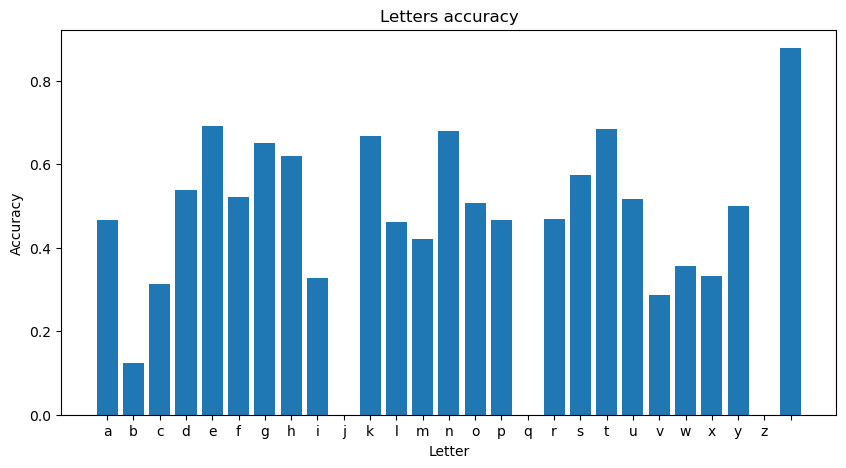

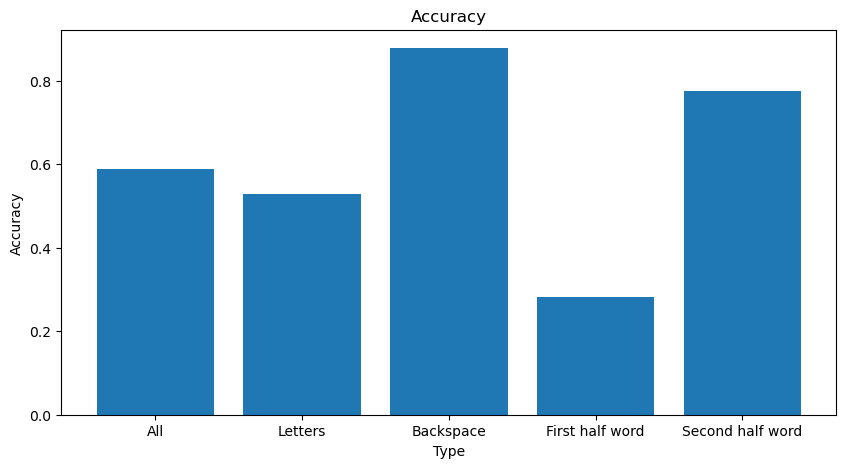

In [86]:
import matplotlib.pyplot as plt

def plot_letters_hist(stats, output_file=None):
    letters = [chr(x) for x in range(ord('a'), ord('z') + 1)] + [' ']
    accuracies = [stats['letters_count'][char]['accuracy'] for char in letters]

    plt.figure(figsize=(10, 5))
    plt.bar(letters, accuracies)
    plt.xlabel('Letter')
    plt.ylabel('Accuracy')
    plt.title('Letters accuracy')
    
    if output_file is not None:
        plt.savefig(output_file)
    else:
        plt.show()
    
def plot_accuracy_hist(stats, output_file=None):
    accuracies = [stats['accuracy'], stats['letters_accuracy'], stats['backspace_accuracy'], stats['first_half_word_accuracy'], stats['second_half_word_accuracy']]
    names = ['All', 'Letters', 'Backspace', 'First half word', 'Second half word']

    plt.figure(figsize=(10, 5))
    plt.bar(names, accuracies)
    plt.xlabel('Type')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    
    if output_file is not None:
        plt.savefig(output_file)
    else:
        plt.show()
    
plot_letters_hist(stats)
plot_accuracy_hist(stats)

In [89]:
import os
os.path.join(os.path.dirname('./model.pt'), 'evaluation')

'./evaluation'

# Fine-tuning

In [2]:
import torch
from transformers import ReformerModelWithLMHead, ReformerConfig
from torch.utils.data import Dataset, DataLoader
from data_scripts.data_reformer import Corpus

In [18]:
corpus: Corpus = Corpus("./data/sentences")

In [19]:
class TextDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+1:idx+self.block_size+1]
        return x, y

In [20]:
block_size = 128  # Sequence length to consider for training

train_dataset = TextDataset(corpus.train, block_size)
valid_dataset = TextDataset(corpus.valid, block_size)
test_dataset = TextDataset(corpus.test, block_size)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
conf = ReformerConfig.from_pretrained("google/reformer-enwik8")
conf.axial_pos_embds = False
conf.max_position_embeddings = 512
model = ReformerModelWithLMHead.from_pretrained("google/reformer-enwik8", config=conf)
model = model.to(device)

Some weights of the model checkpoint at google/reformer-enwik8 were not used when initializing ReformerModelWithLMHead: ['reformer.embeddings.position_embeddings.weights.0', 'reformer.embeddings.position_embeddings.weights.1']
- This IS expected if you are initializing ReformerModelWithLMHead from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ReformerModelWithLMHead from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ReformerModelWithLMHead were not initialized from the model checkpoint at google/reformer-enwik8 and are newly initialized: ['reformer.embeddings.position_embeddings.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

In [6]:
print(model)

ReformerModelWithLMHead(
  (reformer): ReformerModel(
    (embeddings): ReformerEmbeddings(
      (word_embeddings): Embedding(258, 1024)
      (position_embeddings): PositionEmbeddings(
        (embedding): Embedding(512, 1024)
      )
    )
    (encoder): ReformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x ReformerLayer(
          (attention): ReformerAttention(
            (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (self_attention): LocalSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): ReformerSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=False)
            )
          )
          (feed_forward): ChunkReformerFeedForward(
            (layer_norm): LayerNorm((1024,

In [7]:
print(model.config)

ReformerConfig {
  "_name_or_path": "google/reformer-enwik8",
  "architectures": [
    "ReformerModelWithLMHead"
  ],
  "attention_head_size": 128,
  "attn_layers": [
    "local",
    "local",
    "lsh",
    "local",
    "local",
    "local",
    "lsh",
    "local",
    "local",
    "local",
    "lsh",
    "local"
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": false,
  "axial_pos_embds_dim": [
    256,
    768
  ],
  "axial_pos_shape": [
    128,
    512
  ],
  "chunk_size_lm_head": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "feed_forward_size": 4096,
  "hash_seed": null,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.2,
  "local_attn_chunk_length": 128,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 1,
  "lsh_attention_probs_dropout_prob": 0.1,
  "lsh_attn_chunk_length": 256,
  "lsh_num_chunks_after": 0,
  "

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
def train(model, dataloader, optimizer, criterion, epoch, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_predictions = 0
    
    for batch_idx, (input_ids, targets) in enumerate(dataloader):
        # Move data to device
        input_ids = input_ids.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(input_ids)
        loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), targets.view(-1))
        
        # Accuracy
        _, predictions = torch.max(outputs.logits, -1)
        total_correct += (predictions == targets).sum().item()
        total_predictions += len(targets.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Logging
        if (batch_idx + 1) % 10 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            print(f'Epoch [{epoch}], Step [{batch_idx +1}/{len(dataloader)}], Loss: {avg_loss:.4f}, Accuracy: {total_correct / total_predictions:.4f}')

    avg_epoch_loss = total_loss / len(dataloader)
    print(f'====> Epoch: {epoch} Average loss: {avg_epoch_loss:.4f}')
    return avg_epoch_loss

In [27]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    
    total_loss = 0
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for input_ids, targets in dataloader:
            
            # Move data to device        
            input_ids = input_ids.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(input_ids)
            
            loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), targets.view(-1))
            total_loss += loss.item()
            
            # Accuracy
            _, predictions = torch.max(outputs.logits, -1)
            total_correct += (predictions == targets).sum().item()
            total_predictions += len(targets.view(-1))

    avg_loss = total_loss / len(dataloader)
    print(f'====> Evaluation Average loss: {avg_loss:.4f}, Accuracy: {total_correct / total_predictions:.4f}')
    return avg_loss

In [28]:
num_epochs = 5  # Set the number of epochs

best_valid_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    print(f'\n===== Epoch {epoch} =====')

    # Training
    train_loss = train(model, train_loader, optimizer, criterion, epoch, device)

    # Validation
    valid_loss = evaluate(model, valid_loader, criterion, device)

    # Save the model if validation loss has decreased
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print('Model saved!\n')


===== Epoch 1 =====
Epoch [1], Step [10/14746], Loss: 3.1769, Accuracy: 0.1688
Epoch [1], Step [20/14746], Loss: 2.9995, Accuracy: 0.1887
Epoch [1], Step [30/14746], Loss: 2.9410, Accuracy: 0.1956


KeyboardInterrupt: 

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
test_loss = evaluate(model, test_loader, criterion, device)
print(f'\nTest Loss: {test_loss:.4f}')